In [1]:
import numpy as np
import pandas as pd

In [2]:
# !curl -O http://files.grouplens.org/datasets/movielens/ml-100k.zip
# !unzip ml-100k.zip

In [3]:
ls

cat_de_3year.7z        Prepare Data for Deep Recommender.ipynb  xml_parse/
cat_de_3year.csv       README.md
DataExploration.ipynb  V1 from blog.ipynb


Most recommendation models consist of building a user-by-item matrix with some sort of "interaction" number in each cell. If one includes the numerical ratings that users give items, then this is called an explicit feedback model. Alternatively, one may include implicit feedback which are actions by a user that signify a positive or negative preference for a given item (such as viewing the item online). These two scenarios often must be treated differently.

In the case of the MovieLens dataset, we have ratings, so we will focus on explicit feedback models. First, we must construct our user-item matrix. We can easily map user/item ID's to user/item indices by removing the "Python starts at 0" offset between them.

In [11]:
users_items_pivot_matrix_df = df.pivot(index='user_id', 
                                       columns='item_id', 
                                       values='rating').fillna(0)

users_items_pivot_matrix_df.head(10)

## this is better then
# ratings = np.zeros((n_users, n_items))
# for row in df.itertuples():
#     ratings[row[1]-1, row[2]-1] = row[3]
# ratings

item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,5.0,0.0,0.0,5.0,5.0,5.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,5.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
ratings = users_items_pivot_matrix_df.as_matrix()
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 6.30%


In this dataset, every user has rated at least 20 movies which results in a reasonable sparsity of 6.3%. This means that 6.3% of the user-item ratings have a value. Note that, although we filled in missing ratings as 0, we should not assume these values to truly be zero. More appropriately, they are just empty entries. We will split our data into training and test sets by removing 10 ratings per user from the training set and placing them in the test set.

In [15]:
### a weird way to do test-train split
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=10, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

train, test = train_test_split(ratings)

## Collaborative filtering

We will focus on collaborative filtering models today which can be generally split into two classes: user- and item-based collaborative filtering. In either scenario, one builds a similarity matrix. For user-based collaborative filtering, the user-similarity matrix will consist of some distance metric that measures the similarity between any two pairs of users. Likewise, the item-similarity matrix will measure the similarity between any two pairs of items.

A common distance metric is cosine similarity. The metric can be thought of geometrically if one treats a given user's (item's) row (column) of the ratings matrix as a vector. For user-based collaborative filtering, two users' similarity is measured as the cosine of the angle between the two users' vectors. For users ${u}$ and ${u'}$, the cosine similarity is

$$ sim(u, u') = cos(\theta{}) = \frac{\textbf{r}_{u} \dot{} \textbf{r}_{u'}}{\| \textbf{r}_{u} \| \| \textbf{r}_{u'} \|} = \sum_{i} \frac{r_{ui}r_{u'i}}{\sqrt{\sum\limits_{i} r_{ui}^2} \sqrt{\sum\limits_{i} r_{u'i}^2} } $$
This can be written as a for-loop with code, but the Python code will run quite slow; instead, one should try to express any equation in terms of NumPy functions. I've included a slow and fast version of the cosine similarity function below. The slow function took so long that I eventually canceled it because I got tired of waiting. The fast function, on the other hand, takes around 200 ms.

The cosine similarity will range from 0 to 1 in our case (because there are no negative ratings). Notice that it is symmetric and has ones along the diagonal.

In [16]:
def slow_similarity(ratings, kind='user'):
    if kind == 'user':
        axmax = 0
        axmin = 1
    elif kind == 'item':
        axmax = 1
        axmin = 0
    sim = np.zeros((ratings.shape[axmax], ratings.shape[axmax]))
    for u in range(ratings.shape[axmax]):
        for uprime in range(ratings.shape[axmax]):
            rui_sqrd = 0.
            ruprimei_sqrd = 0.
            for i in range(ratings.shape[axmin]):
                sim[u, uprime] = ratings[u, i] * ratings[uprime, i]
                rui_sqrd += ratings[u, i] ** 2
                ruprimei_sqrd += ratings[uprime, i] ** 2
            sim[u, uprime] /= rui_sqrd * ruprimei_sqrd
    return sim

def fast_similarity(ratings, kind='user', epsilon=1e-9):
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = ratings.dot(ratings.T) + epsilon
    elif kind == 'item':
        sim = ratings.T.dot(ratings) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

In [17]:
%timeit fast_similarity(train, kind='user')

29 ms ± 1.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
user_similarity = fast_similarity(train, kind='user')
item_similarity = fast_similarity(train, kind='item')
print(item_similarity[:4, :4])

[[ 1.          0.40013694  0.32728516  0.45187109]
 [ 0.40013694  1.          0.28076469  0.50251831]
 [ 0.32728516  0.28076469  1.          0.3316598 ]
 [ 0.45187109  0.50251831  0.3316598   1.        ]]


## ALS

In [41]:
cd ..

C:\Users\vladyslavp


In [4]:
raw_df = pd.read_csv('cat_de_3year.csv', encoding = "utf-8")#, nrows = 100000)

In [29]:
## to start let us take a sample of our data
sample_df = raw_df.sample(5000000)
sample_df.head()

,SCM_N_ORDER_POS_NR,SCM_N_ORDER_NR,SCM_N_ORDER_NR_NC,TDT_T_KEY_ORDER_DATE,ART_N_KEY_ARTICLE,PPR_N_KEY_PHYS_PRODUCT,CUS_N_KEY_CUSTOMER,SCM_D_QUANTITY,PPR_N_PHY_ARTICLE_ID,PPR_N_PHY_PRODUCT_ID
35514955,398011580,93250186,0,27-AUG-17,1641073,69215150,3902605,0.5000,62694,23103
44169760,452295069,106067842,0,06-MAR-18,1941753,103019919,4347464,1.0000,68943,49112
38832930,417910618,97970543,0,08-NOV-17,2265498,133919126,16686856,1.0000,76492,54066
7053064,240366688,57056749,57056749,26-AUG-15,1289627,61897067,12270869,1.0000,60572,44462
16566435,287483239,67924664,0,27-APR-16,1277212,26302137,12330131,0.9982,44154,33417


In [30]:
sample_df.drop(['SCM_N_ORDER_POS_NR','SCM_N_ORDER_NR_NC', 'SCM_N_ORDER_NR_NC', 'PPR_N_KEY_PHYS_PRODUCT', 'SCM_N_ORDER_NR', 'ART_N_KEY_ARTICLE','PPR_N_PHY_ARTICLE_ID'], axis=1, inplace=True)
sample_df.head()

,TDT_T_KEY_ORDER_DATE,CUS_N_KEY_CUSTOMER,SCM_D_QUANTITY,PPR_N_PHY_PRODUCT_ID
35514955,27-AUG-17,3902605,0.5000,23103
44169760,06-MAR-18,4347464,1.0000,49112
38832930,08-NOV-17,16686856,1.0000,54066
7053064,26-AUG-15,12270869,1.0000,44462
16566435,27-APR-16,12330131,0.9982,33417


In [32]:
tmp = sample_df.groupby(['CUS_N_KEY_CUSTOMER', 'PPR_N_PHY_PRODUCT_ID']).count()
tmp.reset_index(level=tmp.index.names, inplace=True)
interactions_df = tmp.rename(index=str, columns = {'CUS_N_KEY_CUSTOMER': 'user_id', 
                                                   'PPR_N_PHY_PRODUCT_ID': 'item_id', 
                                                   'TDT_T_KEY_ORDER_DATE': 'timestamp', 
                                                   'SCM_D_QUANTITY': 'rating'})
interactions_df.head()

,user_id,item_id,timestamp,rating
0,22,15896,1,1
1,22,17576,2,2
2,22,19997,1,1
3,22,25635,4,4
4,22,25966,1,1


In [33]:
df = interactions_df

In [34]:
## we want to filter out users that have only one interaction:
## doing it in a standart way
users_interactions_count_df = interactions_df.groupby(['user_id', 'item_id']).size().groupby('user_id').size()
print('# users: %d' % len(users_interactions_count_df))
users_with_enough_interactions_df = users_interactions_count_df[users_interactions_count_df >= 10].reset_index()[['user_id']]
print('# users with at least 10 interactions: %d' % len(users_with_enough_interactions_df))

# users: 725208
# users with at least 10 interactions: 99166


In [35]:
print('# of interactions: %d' % len(interactions_df))
interactions_from_selected_users_df = interactions_df.merge(users_with_enough_interactions_df, 
               how = 'right',
               left_on = 'user_id',
               right_on = 'user_id')
print('# of interactions from users with at least 10 interactions: %d' % len(interactions_from_selected_users_df))

# of interactions: 3456690
# of interactions from users with at least 10 interactions: 1747721


In [36]:
####
# restricted to \geq 10 interactions
###
interactions_restricted_df = interactions_from_selected_users_df

In [37]:
interactions_restricted_df.head()

,user_id,item_id,timestamp,rating
0,22,15896,1,1
1,22,17576,2,2
2,22,19997,1,1
3,22,25635,4,4
4,22,25966,1,1


In [38]:
users_items_pivot_matrix_df = interactions_restricted_df.pivot(index='user_id', 
                                       columns='item_id', 
                                       values='rating').fillna(0)

users_items_pivot_matrix_df.head(10)

item_id,1078,1080,1092,1131,1164,1168,1234,1404,1408,1452,...,55891,55997,56168,56169,56172,56272,56978,56979,57073,57319
user_id,,,,,,,,,,,,,,,,,,,,,
22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
205,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
289,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
413,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
502,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
522,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
ratings = users_items_pivot_matrix_df.as_matrix()
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 0.78%


## The matrix is still way more sparse than the one in the M10K dataset that is usually used for benchmarking
> Perhaps we shoudl filter out even more

In [40]:
users_items_pivot_matrix_df.shape

(99166, 2248)

In [41]:
# Load data from disk
#names = ['user_id', 'item_id', 'rating', 'timestamp']
#df = pd.read_csv('u.data', sep='\t', names=names)
## _users = users_items_pivot_matrix_df.user_id.unique().shape[0]
# n_items = users_items_pivot_matrix_df.item_id.unique().shape[0]
n_users, n_items = users_items_pivot_matrix_df.shape

In [42]:
# Create r_{ui}, our ratings matrix
# ratings = np.zeros((n_users, n_items))
# for row in df.itertuples():
#     ratings[row[1]-1, row[2]-1] = row[3]

# Split into training and test sets. 
# Remove 10 ratings for each user 
# and assign them to the test set
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=10, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

train, test = train_test_split(ratings)

In [43]:
from sklearn.metrics import mean_squared_error
def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [44]:
from numpy.linalg import solve

class ExplicitMF():
    def __init__(self, 
                 ratings, 
                 n_factors=40, 
                 item_reg=0.0, 
                 user_reg=0.0,
                 verbose=False):
        """
        Train a matrix factorization model to predict empty 
        entries in a matrix. The terminology assumes a 
        ratings matrix which is ~ user x item
        
        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings
        
        n_factors : (int)
            Number of latent factors to use in matrix 
            factorization model
        
        item_reg : (float)
            Regularization term for item latent factors
        
        user_reg : (float)
            Regularization term for user latent factors
        
        verbose : (bool)
            Whether or not to printout training progress
        """
        
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_reg = item_reg
        self.user_reg = user_reg
        self._v = verbose

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type='user'):
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        if type == 'user':
            # Precompute
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in range(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI), 
                                             ratings[u, :].dot(fixed_vecs))
        elif type == 'item':
            # Precompute
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in range(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), 
                                             ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors

    def train(self, n_iter=10):
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors
        self.user_vecs = np.random.random((self.n_users, self.n_factors))
        self.item_vecs = np.random.random((self.n_items, self.n_factors))
        
        self.partial_train(n_iter)
    
    def partial_train(self, n_iter):
        """ 
        Train model for n_iter iterations. Can be 
        called multiple times for further training.
        """
        ctr = 1
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print ('\tcurrent iteration: {}'.format(ctr))
            self.user_vecs = self.als_step(self.user_vecs, 
                                           self.item_vecs, 
                                           self.ratings, 
                                           self.user_reg, 
                                           type='user')
            self.item_vecs = self.als_step(self.item_vecs, 
                                           self.user_vecs, 
                                           self.ratings, 
                                           self.item_reg, 
                                           type='item')
            ctr += 1
    
    def predict_all(self):
        """ Predict ratings for every user and item. """
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)
                
        return predictions
    def predict(self, u, i):
        """ Single user and item prediction. """
        return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
    
    def calculate_learning_curve(self, iter_array, test):
        """
        Keep track of MSE as a function of training iterations.
        
        Params
        ======
        iter_array : (list)
            List of numbers of iterations to train for each step of 
            the learning curve. e.g. [1, 5, 10, 20]
        test : (2D ndarray)
            Testing dataset (assumed to be user x item).
        
        The function creates two new class attributes:
        
        train_mse : (list)
            Training data MSE values for each value of iter_array
        test_mse : (list)
            Test data MSE values for each value of iter_array
        """
        iter_array.sort()
        self.train_mse =[]
        self.test_mse = []
        iter_diff = 0
        for (i, n_iter) in enumerate(iter_array):
            if self._v:
                print ('Iteration: {}'.format(n_iter))
            if i == 0:
                self.train(n_iter - iter_diff)
            else:
                self.partial_train(n_iter - iter_diff)

            predictions = self.predict_all()

            self.train_mse += [get_mse(predictions, self.ratings)]
            self.test_mse += [get_mse(predictions, test)]
            if self._v:
                print ('Train mse: ' + str(self.train_mse[-1]))
                print ('Test mse: ' + str(self.test_mse[-1]))
            iter_diff = n_iter

In [45]:
MF_ALS = ExplicitMF(train, n_factors=40, \
                    user_reg=0.0, item_reg=0.0)
iter_array = [1, 2, 5, 10, 25, 50, 100]
MF_ALS.calculate_learning_curve(iter_array, test)

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def plot_learning_curve(iter_array, model):
    plt.plot(iter_array, model.train_mse, \
             label='Training', linewidth=5)
    plt.plot(iter_array, model.test_mse, \
             label='Test', linewidth=5)


    plt.xticks(fontsize=16);
    plt.yticks(fontsize=16);
    plt.xlabel('iterations', fontsize=30);
    plt.ylabel('MSE', fontsize=30);
    plt.legend(loc='best', fontsize=20);

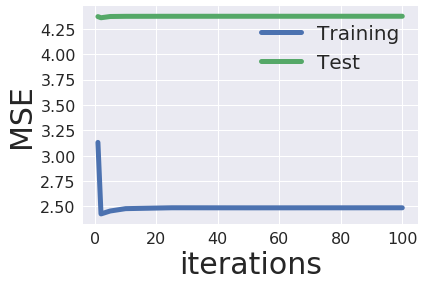

In [47]:
plot_learning_curve(iter_array, MF_ALS)

In [48]:
MF_ALS = ExplicitMF(train, n_factors=40, \
                    user_reg=1., item_reg=1.)

iter_array = [1, 2, 5, 10, 25, 50, 100]
MF_ALS.calculate_learning_curve(iter_array, test)

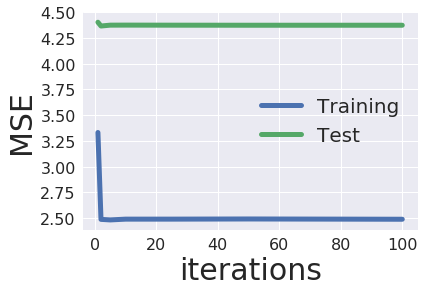

In [49]:
plot_learning_curve(iter_array, MF_ALS)

In [ ]:
MF_ALS = ExplicitMF(train, n_factors=20, \
                    user_reg=4., item_reg=4.)

iter_array = [1, 2, 5]
MF_ALS.calculate_learning_curve(iter_array, test)